# SMC2017: Exercise sheet IV

## Setup

In [1]:
import numpy as np
from scipy import stats

from tqdm import tqdm_notebook

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

## IV.1 Particle Metropolis-Hastings

Consider the state-space model
$$
\begin{array}{rcll}
x_t & = & \cos\left(\theta x_{t - 1}\right) + v_t, &\qquad v_t \sim \mathcal{N}(0, 1)\\
y_t & = & x_t + e_t, &\qquad e_t \sim \mathcal{N}(0, 1) \\
x_0 & \sim & \mathcal{N}(0, 1) &
\end{array}
$$
which admits the probabilistic model
$$
\begin{array}{lcl}
p(x_0) & = & \mathcal{N}\left(x_0;\,0,\,1\right) \\
p(x_t\,\big|\,x_{t - 1}) & = & \mathcal{N}\left(x_t;\,\cos\left(\theta x_{t - 1}\right),\,1\right) \\
p(y_t\,\big|\,x_t) & = & \mathcal{N}\left(y_t;\,x_t,\,1\right)
\end{array}
$$

For now, I will use the bootstrap particle filter (for simplicity).

### Simulate data

During the simulation $\theta = 1$ will be assumed. During the inference it will be assumed that $\theta \sim \mathcal{N}(0, 1)$.

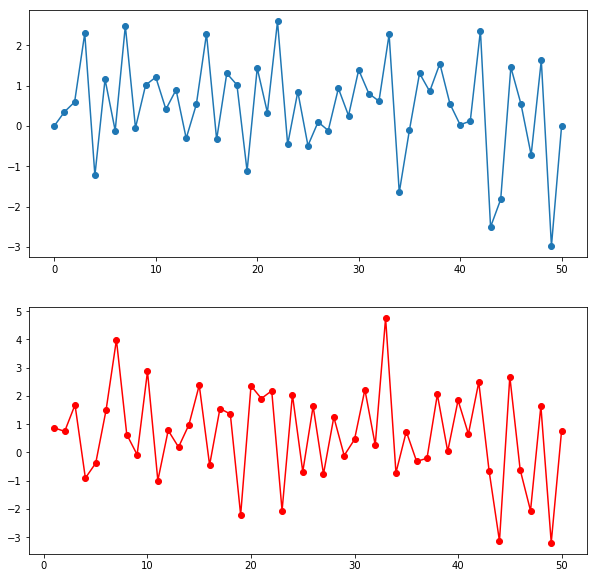

In [2]:
T = 50

xs_sim = np.zeros((T + 1,))
ys_sim = np.zeros((T,))

# Initial state
xs_sim[0] = 0.
for t in range(T):
    xs_sim[t + 1] = np.cos(xs_sim[t]) + stats.norm.rvs()
    
ys_sim = xs_sim[1:] + stats.norm.rvs(0, 1, T)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(xs_sim, 'o-')
axs[1].plot(range(1, T + 1), ys_sim, 'o-r')

Bootstrap particle filter giving an estimate $\widehat{z}_\theta$ of the joint likelihood $p(y_{1:T}\,\big|\,\theta)$.

In [3]:
def log_likelihood_bootstrap_pf(y, N=20, theta=1):
    # Cumulatively build up log-likelihood
    ll = 0.0
    # Initialisation
    samples = stats.norm.rvs(0, 1, N)
    weights = 1 / N * np.ones((N,))
    
    # Determine the number of time steps
    T = len(y)
    # Loop through all time steps
    for t in range(T):
        # Resample
        ancestors = np.random.choice(samples, size=N, 
                                     replace=True, p=weights)
        
        # Propagate
        samples = stats.norm.rvs(0, 1, N) + np.cos(theta * ancestors)
        
        # Weight
        weights = stats.norm.logpdf(y[t], loc=samples, scale=1)
        # Calculate the max of the weights
        max_weights = np.max(weights)
        # Subtract the max
        weights = weights - max_weights
        # Update log-likelihood
        ll += max_weights + np.log(np.sum(np.exp(weights))) - np.log(N)

        # Normalize weights to be probabilities
        weights = np.exp(weights) / np.sum(np.exp(weights))
  
    return ll

In [4]:
log_likelihood_bootstrap_pf(ys_sim, N=50, theta=3)

-102.29933166823245

As a proposal we can use $q(\theta'\,\big|\,\theta[k - 1]) = \mathcal{N}\left(\theta';\,\theta[k - 1], \tau\right)$ with an appropriately chosen $\tau$.

Implement a Metropolis-Hastings sampler with the above.

In [12]:
def particle_metropolis_hastings(y, M=10000, N=20, tau=1):
    theta = np.zeros((M + 1,))
    alpha = np.zeros((M,))
    z = np.zeros((M + 1,))
    
    # Initial state
    theta[0] = 0
    z[0] = log_likelihood_bootstrap_pf(y, N=N, theta=theta[0])
    
    # Iterate the chain
    t = tqdm_notebook(range(M))
    for i in t:
        # Sample a new value
        theta_prop = stats.norm.rvs(theta[i], tau, 1)
        # Sample to be compared to the acceptance probability
        u = stats.uniform.rvs()
        
        # Terms in the second part of the acceptance probability -
        # Proposal is symmetric, so terms containing the proposal will
        # cancel each other out
        z_prop = log_likelihood_bootstrap_pf(y, N=N, theta=theta_prop)
        num = z_prop + stats.norm.logpdf(theta_prop)
        denom = z[i] + stats.norm.logpdf(theta[i])
            
        # Acceptance probability
        alpha[i] = min(1, np.exp(num - denom))
        t.set_postfix({'a_mean': np.mean(alpha[:(i + 1)])})
        # Set next state depending on acceptance probability
        if u <= alpha[i]:
            z[i + 1] = z_prop
            theta[i + 1] = theta_prop
        else:
            z[i + 1] = z[i]
            theta[i + 1] = theta[i]
            
    return theta, alpha

In [13]:
theta, alpha = particle_metropolis_hastings(ys_sim, M=10000, N=50, tau=0.7)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

9993/|/100%|| 9993/10000 [01:51<00:00, 89.90it/s, a_mean=0.231]                                                        

In [15]:
np.mean(alpha)

0.23624512348377344

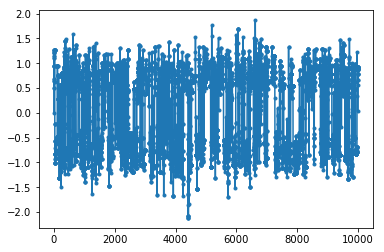

In [17]:
fig, ax = plt.subplots()
ax.plot(theta, '.-')

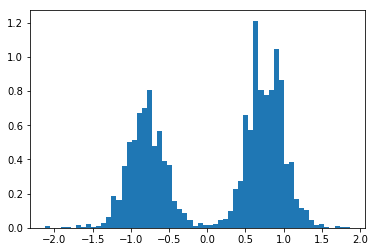

In [22]:
fig, ax = plt.subplots()
ax.hist(theta[2000:], normed=True, bins=60);

## IV.2 Conditional Particle Filter

I will turn the fully adapted particle filter from exercise II.2 into a conditional particle filter by including a reference state trajectory and in each propagation step the refernence state trajectory delivers one of the particles. States and their ancestors will be saved and the algorithm returns a new state trajectory conditional on the old one.

The state-space model under consideration is (normal distribution parametrized with $\sigma$)
$$
\begin{array}{rll}
x_{t + 1} &= \cos(x_t)^2 + v_t, & v_t \sim N(0, 1) \\
y_t &= 2 x_t + e_t, & e_t \sim N(0, 0.1)
\end{array}
$$
which leads to the probabilistic model
$$
\begin{align}
p(x_t\,|\,x_{t - 1}) &= N\left(x_t;\,\cos(x_t)^2,\,1\right) \\
p(y_t\,|\,x_t) &= N\left(y_t;\,2 x_t,\,0.1\right)
\end{align}
$$
This admits the necessary pdfs
$$
\begin{align}
p(y_t\,|\,x_{t - 1}) &= N(y_t;\,2 \cos(x_{t - 1})^2,\,\sqrt{4.01}) \\
p(x_t\,|\,x_{t - 1},\,y_t) &= N\left(x_t;\,\frac{2 y_t + 0.01 \cos(x_{t - 1})^2}{4.01}, \frac{0.1}{\sqrt{4.01}}\right) 
\end{align}
$$

In [101]:
def conditional_FAPF(x_ref, y, N=200):
    # Determine length of data
    T = len(y)
    # Save the paths of all final particles
    xs = np.zeros((N, T + 1))
    # Initialisation
    xs[:, 0] = stats.norm.rvs(0, 1, N)
    # Replace last state with state from reference trajectory
    xs[N - 1, 0] = x_ref[0]
    
    for t in range(T):
        # Calculate resampling weights in case of FAPF
        ws = stats.norm.logpdf(y[t], loc=2*np.power(np.cos(xs[:, t]), 2), 
                               scale=np.sqrt(4.01))
        # Subtract maximum weight
        ws -= np.max(ws)
        # Normalize the resampling weights
        ws = np.exp(ws) / np.sum(np.exp(ws))
            
        # Resample
        ancestors = np.random.choice(range(N), size=N, replace=True, p=ws)
        
        # Propagate
        xs[:, t + 1] = stats.norm.rvs(0, 1, N) * 0.1 / np.sqrt(4.01) + \
            (2 / 4.01) * y[t] + (0.01 / 4.01) * \
            np.power(np.cos(xs[ancestors, t]), 2)
        # Replace last sample with reference trajectory
        ancestors[N - 1] = N - 1
        xs[N - 1, t + 1] = x_ref[t + 1]
        # Update the ancestor lines
        xs[:, 0:t] = xs[ancestors, 0:t]

    # Randomly choose trajectory which will be returned
    # All normalized weights are 1 / N, so that no draw from
    # a categorical distribution is necessary. A uniform draw
    # is satisfactory.
    b = np.random.randint(N)  
    
    return xs[b, :]

Simulate from the model given above.

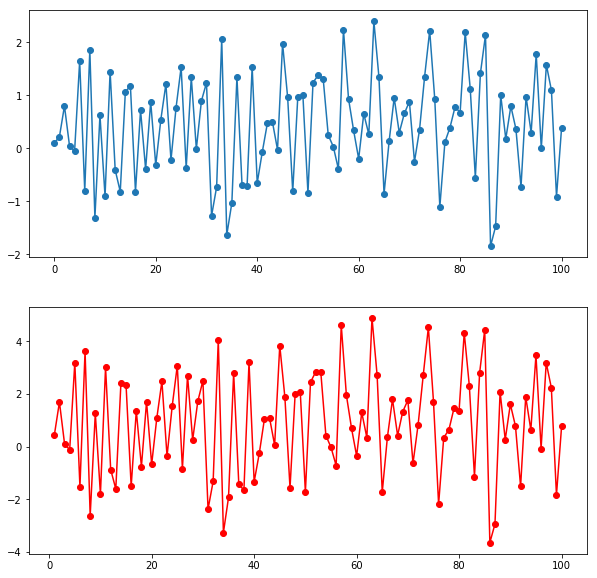

In [56]:
T = 100

# Allocate arrays for results
ys_sim = np.zeros((T,))
xs_sim = np.zeros((T + 1,))
# Initial value for state
xs_sim[0] = 0.1
# Walk through all time steps
for t in range(T):
    xs_sim[t + 1] = np.power(np.cos(xs_sim[t]), 2) + stats.norm.rvs(0, 1, 1)
    ys_sim[t] = 2 * xs_sim[t + 1] + stats.norm.rvs(0, 0.1, 1)
    
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(range(T + 1), xs_sim, 'o-');
axs[1].plot(range(1, T + 1), ys_sim, 'o-r');

This is a Markov kernel which can be used in Gibbs sampling where the parameters and the hidden state are sampled repeatedly consecutively.

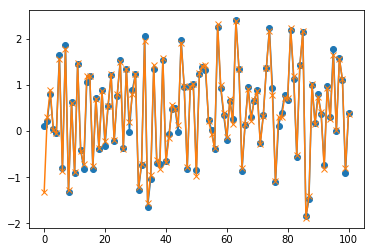

In [151]:
xs = conditional_FAPF(xs_sim, ys_sim, N=1000)

fig, ax = plt.subplots()
ax.plot(xs_sim, 'o-')
ax.plot(xs, 'x-');

## IV.3 Conditional importance sampling

### a) Conditional importance sampling with few particles

Sample from $\pi(x) = \mathcal{N}\left(x\,\big|\,1,\,1\right)$ by using conditional importance sampling with the proposal $q(x) = \mathcal{N}\left(x\,\big|\,0,\,1\right)$.

In [23]:
def cond_imp_sampling_kernel(x, N=2):
    # Sample new proposals
    xs = stats.norm.rvs(0, 1, N)
    # Set the last sample to the reference
    xs[N - 1] = x
    
    # Calculate weights
    ws = stats.norm.logpdf(xs, loc=1, scale=1) - \
        stats.norm.logpdf(xs, loc=0, scale=1)
    ws -= np.max(ws)
    ws = np.exp(ws) / np.sum(np.exp(ws))
    
    return xs[np.random.choice(range(N), size=1, p=ws)[0]]

Use that kernel to sample from the target distribution.

In [24]:
def cond_imp_sampling_mcmc(M=1000, N=2):
    # Initialisation
    xs = np.zeros((M + 1,))
    for m in tqdm_notebook(range(M)):
        xs[m + 1] = cond_imp_sampling_kernel(xs[m], N=N)
        
    return xs

Run the sampler

In [25]:
xs = cond_imp_sampling_mcmc(M=70000)

HBox(children=(IntProgress(value=0, max=70000), HTML(value='')))

Plot the result

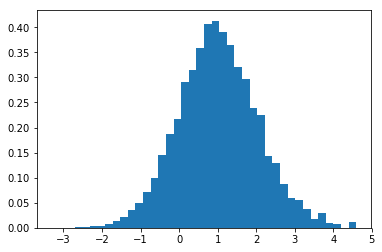

In [28]:
fig, ax = plt.subplots()
ax.hist(xs, normed=True, bins=40);

### b) Lower bound for probability that draw from cond. imp. sampling kernel falls in a set $A$

Theoretical exercise. Solution will be in `exercises_on_paper`.

## IV.4 An SMC sampler for localization

A point $x_0$ is supposed to be localized in the plane $[-12,\,12]^2$. 

There are some measurements $y_{1:M}$ which are corrupted by heavy-tailed noise from an exponential distribution.

We want to find the distribution $p\left(x_0\,\big|\,y_{1:M}\right)$.

### a) Simulate data

$M$ simulated measurements from the model
$$
\begin{align}
    y_t^1 &= x_0^1 + n_m^1 b_m^1 \\
    y_t^2 &= x_0^2 + n_m^2 b_m^2
\end{align}
$$
where
$$
\begin{align}
    m &= 1, 2, \dots, M \\
    x_0 &= \left(x_0^1, x_0^2\right) \\
    n_m^1, n_m^2 &\sim \mathrm{Exp}\left(2\right) \\
    \mathbb{P}\left(b_m^1 = 1\right) &= \mathbb{P}\left(b_m^1 = -1\right) = \frac{1}{2}
\end{align}
$$
and analogously for $b_m^2$.

In [336]:
M = 50
x0 = np.array([8.0, -5.5])
ns = np.reshape(stats.expon.rvs(scale=2, size=2 * M), (2, M))
bs = np.reshape(np.random.choice([-1, 1], size=2 * M, 
                                 replace=True, p=[0.5, 0.5]), 
                (2, M))

ys = np.reshape(np.repeat(x0, M), (2, M)) + ns * bs
ys = ys.T

Visualize simulated observations and true $x_0$

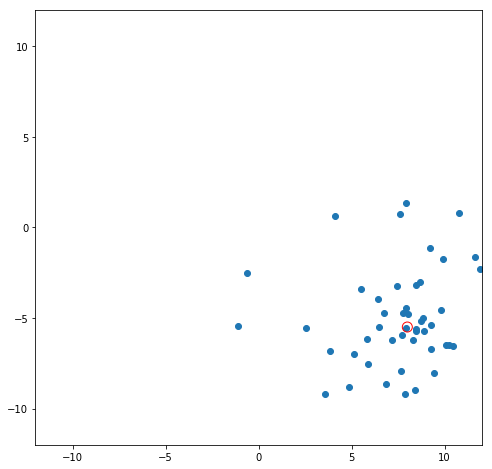

In [337]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(ys[:, 0], ys[:, 1])
ax.set_xlim([-12, 12])
ax.set_ylim([-12, 12])
ax.scatter(x0[0], x0[1], facecolors='none', edgecolors='r', s=100)

### b) Likelihood

As derived on paper, it holds that
$$
p\left(y_m^j\,\big|\,x_0^j\right) = 
\begin{cases}
    \frac{1}{4} \exp\left(-\frac{y_m^j - x_0^j}{2}\right) & y_m^j > x_0 \\
    \frac{1}{4} \exp\left(\frac{y_m^j - x_0^j}{2}\right) & y_m^j < x_0
\end{cases}
$$
and since the components of $y_m$ are independent we get
$$
p\left(y_m\,\big|\,x_0\right) = p\left(y_m^1\,\big|\,x_0^1\right) \cdot p\left(y_m^2\,\big|\,x_0^2\right) 
$$

In [228]:
def log_likelihood(x, ys):
    return np.sum(np.log(0.25) + 0.5 * 
                  np.power(-1, ((ys - x) > 0).astype('int')) * (ys - x))

### c) Metropolis-Hastings kernel for $\pi_k$

This function evaluates $\log\left(\pi_k\right)$

In [348]:
def tempered_prob(x, ys, k, K=10):
    # k / K comes from likelihood tempering
    return k / K * log_likelihood(x, ys) + \
        stats.multivariate_normal.logpdf(x, mean=[0, 0],
                                         cov=7 * np.eye(2))

The Metropolis-Hastings kernel produces one new sample of the Markov chain, conditional on the last sample.

In [349]:
def mh_kernel(x, ys, k, K=10, tau=0.5):
    # Propose a new value
    x_prop = stats.multivariate_normal.rvs(mean=x, 
                                           cov=tau**2 * np.eye(2), 
                                           size=1)

    # Terms in the second part of the acceptance probability
    # Proposal is symmetric, so terms containing the proposal will
    # cancel each other out
    
    # Acceptance probability
    alpha = min(0, tempered_prob(x_prop, ys, k, K=K) - 
                   tempered_prob(x, ys, k, K=K))

    # Sample to be compared to the acceptance probability
    u = stats.uniform.rvs()

    # Set next state depending on acceptance probability
    if np.log(u) <= alpha:
        return x_prop, np.exp(alpha)
    else:
        return x, np.exp(alpha)

In [241]:
mh_kernel(x0, ys, 2)

(array([ 1.96860289, -5.41608696]), 1.0)

### e) Putting together the actual SMC sampler

In [416]:
def smc_sampler(ys, K=10, N=100, ess_min=50, tau=0.5, progressbar=True):
    # Vectors for saving
    xs = np.zeros((K + 1, N, 2))
    ancs = np.zeros((K, N), dtype='int64')
    ws = np.zeros((K + 1, N))
    
    # Initialisation
    xs[0, :, :] = stats.multivariate_normal.rvs(mean=[0, 0], 
                                                cov=7 * np.eye(2), 
                                                size=N)
    ws[0, :] = 1 / N * np.ones((N,))
    
    if progressbar:
        t = tqdm_notebook(range(K))
    else:
        t = range(K)
    for k in t:
        # Update weights
        for i in range(N):
            ws[k + 1, i] = ws[k, i] + tempered_prob(xs[k, i, :], ys, 
                                                    k=k + 1, K=K) - \
                tempered_prob(xs[k, i, :], ys, k=k, K=K)
        # and normalize them
        ws[k + 1, :] -= np.max(ws[k + 1, :])
        ws[k + 1, :] = np.exp(ws[k + 1, :]) / np.sum(np.exp(ws[k + 1, :]))
            
        # Resample depending on ESS
        if 1 / np.sum(np.power(ws[k + 1, :], 2)) < ess_min:
            ancs[k, :] = np.random.choice(range(N), size=N, 
                                          replace=True, p=ws[k + 1, :])
            ws[k + 1, :] = 1 / N * np.ones((N,))
        else:
            ancs[k, :] = range(N)
            
        # Propagate / Sample from next element in the sequence
        # Here, via a Metropolis-Hastings kernel
        for i in range(N):
            xs[k + 1, i, :] = mh_kernel(xs[k, ancs[k, i], :], ys, 
                                        k=k + 1, K=K, tau=tau)[0]
            
    return xs, ancs, ws

In [421]:
xs, ancs, ws = smc_sampler(ys, N=1000, ess_min=750)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [422]:
np.sum(xs[10, :, 0] * ws[10])

8.0765729243359221

In [423]:
np.sum(xs[10, :, 1] * ws[10])

-5.2716277683590409

### f) Visualisation and testing of the SMC sampling

Sample the probability distributions of interest to be able to draw contour lines.

In [382]:
x = np.arange(-12, 12, 0.25)
y = np.arange(-12, 12, 0.25)

X, Y = np.meshgrid(x, y)

Z = np.zeros((len(x), len(y), 10))

for k in tqdm_notebook(range(10)):
    for i in range(len(x)):
        for j in range(len(y)):
            Z[i, j, k] = tempered_prob(np.array([X[i, j], Y[i, j]]), 
                                       ys, k, K=10)
            
    Z[:, :, k] -= np.max(Z[:, :, k])
    Z[:, :, k] = np.exp(Z[:, :, k])

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

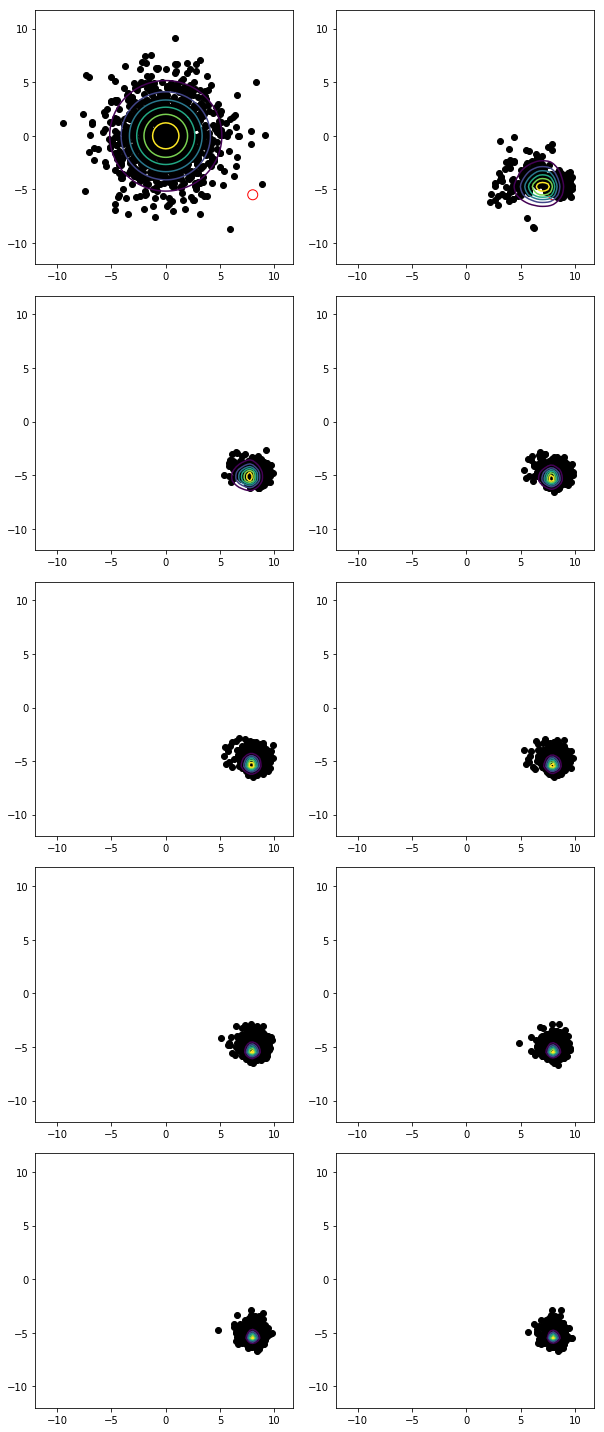

In [424]:
fig, axs = plt.subplots(5, 2, figsize=(8.5, 20))

for k in range(10):
    levels=np.linspace(np.min(Z[:, :, k]), 
                       np.max(Z[:, :, k]), 8)
    axs[k // 2, k % 2].contour(X, Y, Z[:, :, k])
    axs[k // 2, k % 2].scatter(x0[0], x0[1], 
                               facecolors='none', edgecolors='r', s=100)
    axs[k // 2, k % 2].scatter(xs[k, :, 0], xs[k, :, 1], color='k')
    
fig.tight_layout()

### g) Comparison to standard Metropolis Hastings sampler

This is the Metropolis Hastings sampler for the distribution $\pi_k$

In [410]:
def mh_sampler(ys, k=10, K=10, M=1000, tau=0.5, progressbar=True):
    # Prepare vectors for saving
    xs = np.zeros((M + 1, 2))
    alpha = np.zeros((M,))
    
    # Initial state
    # Choose zero as the initial state
    
    # Iterate the chain
    if progressbar:
        t = tqdm_notebook(range(M))
    else:
        t = range(M)
        
    for i in t:
        xs[i + 1], alpha[i] = mh_kernel(xs[i], ys, k, K=K, tau=tau)
        if progressbar:
            t.set_postfix({'mean acc': np.mean(alpha[:(i + 1)])})
       
    return xs, alpha

In [412]:
xs, _ = mh_sampler(ys, M=5000, tau=0.7, progressbar=True)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

In [427]:
means_mh = np.zeros((10, 2))
means_smc = np.zeros((10, 2))

for m in tqdm_notebook(range(10)):
    xs, _ = mh_sampler(ys, M=5000, tau=0.7, progressbar=True)
    means_mh[m, :] = np.mean(xs[500:], axis=0)
    
    xs, _, ws = smc_sampler(ys, N=1000, ess_min=750, progressbar=True)
    means_smc[m, :] = [np.sum(xs[10, :, 0] * ws[10]), 
                       np.sum(xs[10, :, 1] * ws[10])]

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [432]:
np.mean(np.linalg.norm(means_smc - x0, axis=1, ord=1))

0.32460677453673759

In [433]:
np.mean(np.linalg.norm(means_mh - x0, axis=1, ord=1))

0.11474908338956676

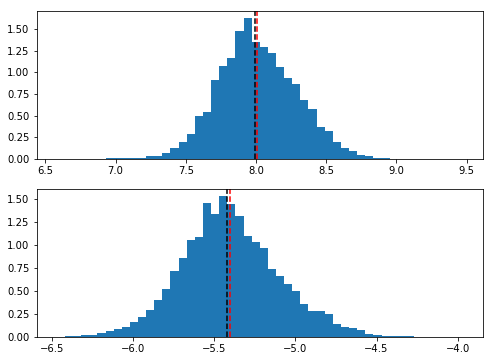

In [342]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

burnin = 1000

axs[0].hist(xs[burnin:, 0], normed=True, bins=50);
axs[0].axvline(np.mean(xs[burnin:, 0]), color='r', linestyle='--')
axs[0].axvline(np.median(xs[burnin:, 0]), color='k', linestyle='--')

axs[1].hist(xs[burnin:, 1], normed=True, bins=50);
axs[1].axvline(np.mean(xs[burnin:, 1]), color='r', linestyle='--')
axs[1].axvline(np.median(xs[burnin:, 1]), color='k', linestyle='--')